In [29]:
from bencodepy import decode
from enum import Enum
from hashlib import sha1, sha256
from os import scandir
from time import monotonic
class Type(Enum):
    UNDEF = 0,
    V1 = 1,
    V2 = 2,
    HYBRID = 3
class Torrent():
    def __init__(self):
        self.sha1 = b''
        self.duplicates = [] # filenames of duplicated files
        self.files = {}
        self.type = Type.UNDEF
    def file(self, f):
        self.parse(open(f, "rb").read())
    def parse(self, b):
        infodict = b[b.find(b'4:info')+6:b.rfind(b'6:sourced2:ip')]
        self.sha1 = sha1(infodict).digest()
        self.sha256 = sha256(infodict).digest()
        self.dict = decode(b)
        if b'pieces' in self.dict.get(b'info'):
            self.dict.get(b'info').pop(b'pieces')
        if b'file tree' in self.dict.get(b'info').keys():
            self.type = Type.V2
            def filetree(names):
                r = {}
                for key in names.keys():
                    if key == b'':
                        return names.get(key).get(b'length')
                    r[key] = filetree(names.get(key))
                return r
            self.files = filetree(self.dict.get(b'info').get(b'file tree'))
            self.dict.get(b'info').pop(b'file tree')
        if b'files' in self.dict.get(b'info').keys():
            if self.type is Type.V2:
                self.type = Type.HYBRID
            else:
                for file in self.dict.get(b'info').get(b'files'):
                    def insert_file(d, path, length, self):
                        name = path.pop()
                        if not len(path):
                            d[name] = length
                            return
                        if name not in d.keys():
                            d[name] = {}
                        insert_file(d[name], path, length, self)
                    file.get(b'path').reverse()
                    insert_file(self.files, file.get(b'path'), file.get(b'length'), self)
                self.type = Type.V1
            self.dict.get(b'info').pop(b'files')
        if not len(self.files):
            self.type = Type.V1
            self.files[self.dict.get(b'info').get(b'name')] = self.dict.get(b'info').get(b'length')
    def paths(self):
        def paths_r(d, path=None):
            if path is None:
                path = []
            for f in d.keys():
                if type(d[f]) is int:
                    z = path.copy()
                    z.append(f)
                    yield z, d[f]
                else:
                    z = path.copy()
                    z.append(f)
                    for z, v in paths_r(d[f], z):
                        yield z, v
        for z, v in paths_r(self.files):
            yield z, v
    def __repr__(self):
        return str(self.__dict__)
    def __hash__(self):
        if len(self.sha1):
            return int.from_bytes(self.sha1, byteorder="big")
        return id(self)
def glob(d):
    r = {}
    for f in scandir(d):
        if f.name.endswith(".torrent") and f.is_file():
            t = Torrent()
            t.file(f.path)
            r[t.sha1] = t
    return r
print("......")
start = monotonic()
torrents = glob("/root/projects/travnik")
print(len(torrents), "@", monotonic()-start, "s")
# t = Torrent()
# t.file("/root/projects/travnik/449a38ef7e042bd2d75e8921aa02f6f244165d9d.torrent")
# print(t.sha1.hex())
# for path, length in t.paths():
#     print(path, length)
# print(t)

......
31190 @ 59.71765779494308 s


In [30]:
s = monotonic()
siz = 0
for sha1, torrent in torrents.items():
    for path, size in torrent.paths():
        siz += size
print(len(v), "@", monotonic()-s, "s", siz/(1024*1024*1024*1024), "TiB")

31190 @ 2.270925747929141 s 173.66823510221093 TiB


In [34]:
s = monotonic()
files = 0
for sha1, torrent in torrents.items():
    files += sum(1 for x in torrent.paths())
print(len(v), "@", monotonic()-s, "s", files)

31190 @ 2.0061122900806367 s 2199626


31190 @ 0.00032011792063713074 s 2199626


<IPython.core.display.Javascript object>


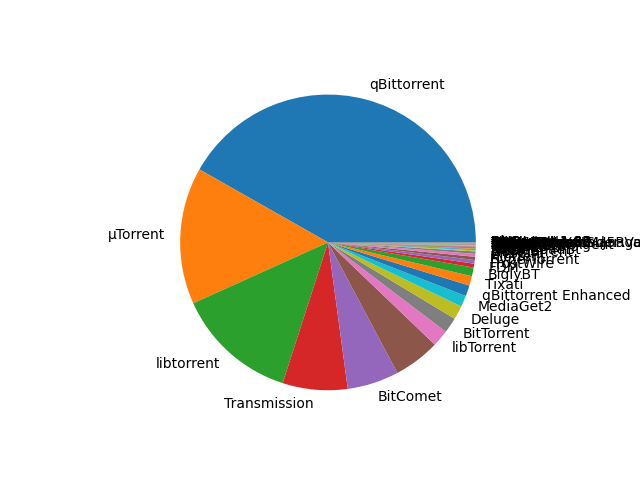

In [96]:
s = monotonic()
def uas(normalize=True):
    odjemalci = {}
    for sha1, torrent in torrents.items():
        odjemalec = torrent.dict.get(b'source').get(b'v')
        if normalize and odjemalec is not None:
            if b'/' in odjemalec:
                odjemalec = odjemalec.split(b'/')[0]
            elif b' (' in odjemalec:
                odjemalec = odjemalec.split(b' (')[0]
            else:
                odjemalec = odjemalec.split(b' ')[0]
            odjemalec = odjemalec.replace(b'\xc2\xb5', b'\xce\xbc').decode()
        if odjemalec not in odjemalci.keys():
            odjemalci[odjemalec] = 1
        else:
            odjemalci[odjemalec] += 1
    odjemalci = [(v, k) for k, v in odjemalci.items()]
    sorted(odjemalci, reverse=True)
    return odjemalci
print(len(v), "@", monotonic()-s, "s", files)
odjemalci = sorted(uas(True), reverse=True)
from matplotlib import pyplot
%matplotlib notebook
fig, axes = pyplot.subplots()
axes.pie([sights for sights, name in odjemalci], labels=[name for sights, name in odjemalci])
fig.show()

31190 @ 0.13778187101706862 s 36


<IPython.core.display.Javascript object>


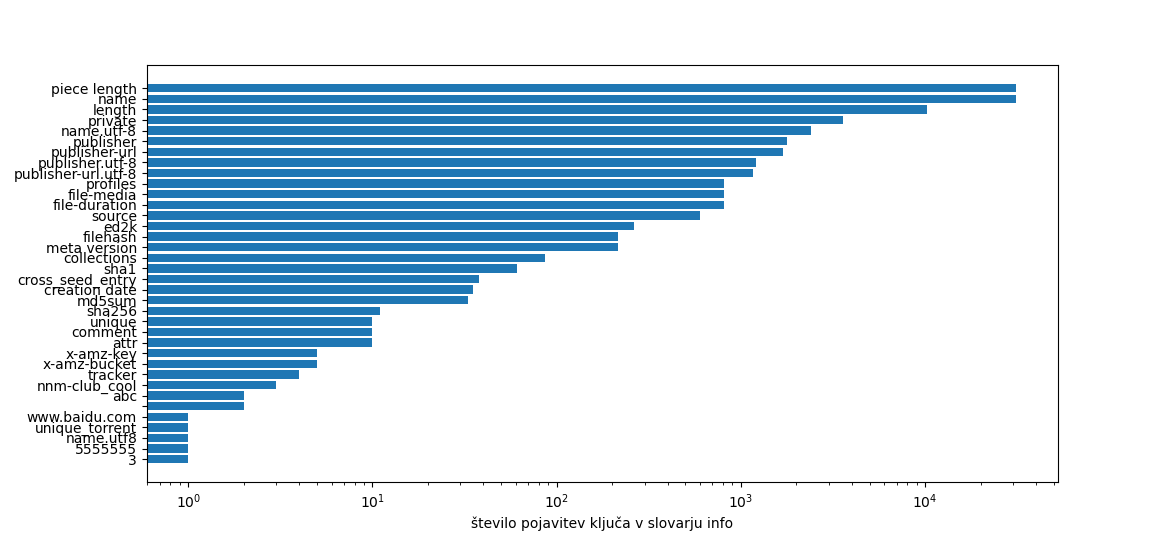

In [143]:
s = monotonic()
keys = {}
for sha1, torrent in torrents.items():
    for key in torrent.dict.get(b'info').keys():
        if key.decode() not in keys.keys():
            value = torrent.dict.get(b'info').get(key)
            if type(value) is bytes:
                try:
                    value = value.decode()
                except UnicodeDecodeError:
                    pass
            keys[key.decode()] = [1, value]
        else:
            keys[key.decode()][0] += 1
print(len(v), "@", monotonic()-s, "s", len(keys))
sort = sorted(keys, key=lambda x: keys[x][0])
%matplotlib notebook
fig, ax = pyplot.subplots();
ax.barh(sort, [keys[x][0] for x in sort])
pyplot.xscale("log")
pyplot.xlabel("število pojavitev ključa v slovarju info")
fig.show() ## TODO komentiraj